In [1]:
#Outlier detection using rolling statistics 
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
df = yf.download("TSLA",
                start = "2019-01-01",
                end = "2020-12-31",
                progress = False)

df["rtn"] = df["Adj Close"].pct_change()
df = df[["rtn"]].copy()
df

,rtn
Date,
2019-01-02,NaN
2019-01-03,-0.031472
2019-01-04,0.057697
2019-01-07,0.054361
2019-01-08,0.001164
...,...
2020-12-23,0.008808
2020-12-24,0.024443
2020-12-28,0.002901


In [2]:
df_rolling = df["rtn"].rolling(window = 21) .agg(["mean", "std"])
df_rolling.columns = ['mean', 'std']


In [3]:
df = df.join(df_rolling)

In [4]:
N_SIGMAS = 3
df["upper"] = df["mean"] + N_SIGMAS * df["std"]
df["lower"] = df["mean"] - N_SIGMAS * df["std"]
#Calculate the upper and lower thresholds:

In [15]:
df["outlier"] = (
    (df["rtn"] > df["upper"]) | (df["rtn"] < df["lower"])
)
df["outlier"].value_counts()

False    500
True       4
Name: outlier, dtype: int64

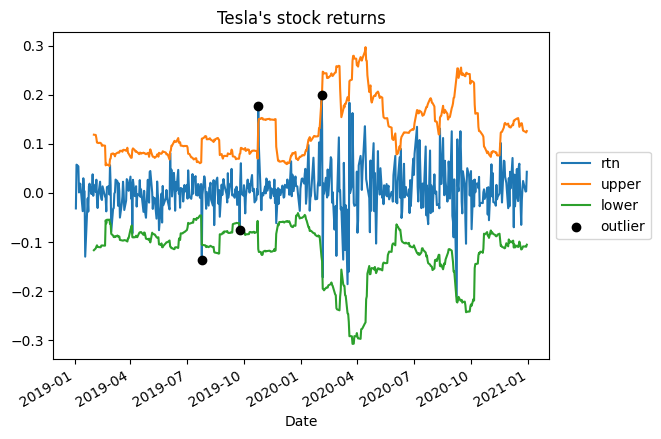

In [16]:
fig, ax = plt.subplots()

df[["rtn", "upper", "lower"]].plot(ax = ax)
ax.scatter(
    df.loc[df["outlier"]].index,
    df.loc[df["outlier"], "rtn"],
    color = "black", label ="outlier",
)

ax.set_title("Tesla's stock returns")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
#Defining functions

In [17]:
def identify_outliers(df, column, window_size, n_sigmas):
    #function for identifying outliers using rolling statistics
    df = df[[column]].copy()
    df_rolling = df.rolling(window = window_size).agg(["mean", "std"])
    df_rolling.columns = df_rolling.columns.droplevel()
    df = df.join(df_rolling)
    df["upper"] = df["mean"] + n_sigmas * df["std"]
    df["lower"] = df["mean"] - n_sigmas * df["std"]
 
    return ((df[column] > df["upper"]) | (df[column] < df["lower"]))

In [19]:
#Outlier detection with the Hampel filter
''' we treat an observation as an outlier if it differs from the 
window’s median by more than a determined number of standard deviations. We can then replace 
such an observation with the window’s median.'''
import yfinance as yf
from sktime.transformations.series.outlier_detection import HampelFilter

df = yf.download("TSLA",
                start = "2019-01-01",
                end = "2020-12-31",
                progress = False)
df["rtn"] = df["Adj Close"].pct_change()

In [20]:
hampel_detector = HampelFilter(window_length = 10,
                              return_bool = True)
# we want to use a window of length 10 (5 observations before and 5 after) and for the filter to return a Boolean flag whether the observation is an outlier or not.
df["outlier"] = hampel_detector.fit_transform(df["Adj Close"])

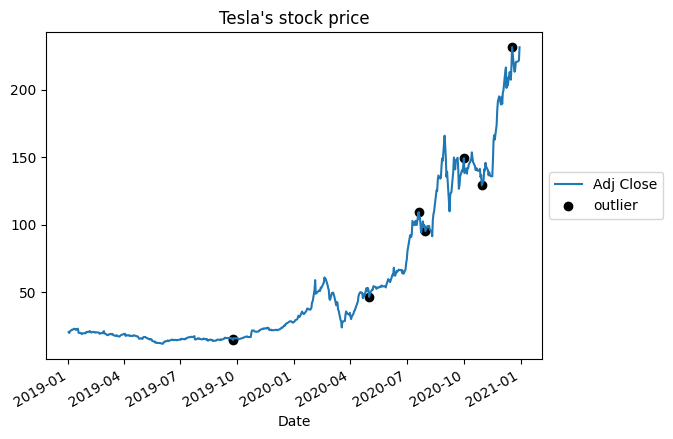

In [21]:
fig, ax = plt.subplots()
df[["Adj Close"]].plot(ax = ax)
ax.scatter(df.loc[df["outlier"]].index,
          df.loc[df["outlier"], "Adj Close"],
          color = "black", label = "outlier")
ax.set_title("Tesla's stock price")
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.show()

C:\Users\Jackson\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\transformations\series\outlier_detection.py:103: UserWarning: Series contains nan values, more nan might be
                added if there are outliers
  Z = self._transform_series(Z)


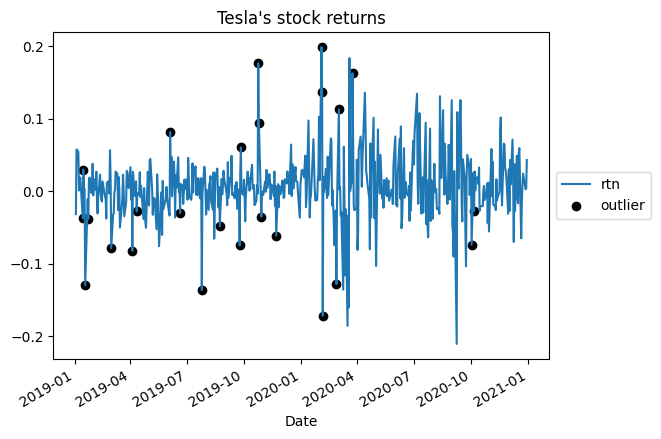

In [24]:
#apply the same filter using the adjusted close prices
df["outlier_rtn"] = hampel_detector.fit_transform(df["rtn"])
fig, ax = plt.subplots()
df[["rtn"]].plot(ax = ax)
ax.scatter(df.loc[df["outlier_rtn"]].index,
          df.loc[df["outlier_rtn"], "rtn"],
          color = "black", label = "outlier")
ax.set_title("Tesla's stock returns")
ax.legend(loc="center left",bbox_to_anchor=(1, 0.5))
plt.show()

In [25]:
df.query("outlier == True and outlier_rtn == True")
#Investigate the overlap in outliers identified for the prices and returns:

,Open,High,Low,Close,Adj Close,Volume,rtn,outlier,outlier_rtn
Date,,,,,,,,,
2019-09-24,16.101334,16.132668,14.840667,14.880667,14.880667,193372500,-0.074701,True,True


In [38]:
#Detecting changepoints in time series
import yfinance as yf
from kats.detectors.cusum_detection import CUSUMDetector
from kats.consts import TimeSeriesData


ModuleNotFoundError: No module named 'kats'

In [34]:
df = yf.download("AAPL",
 start="2020-01-01",
 end="2020-12-31",
 progress=False)
df = df[["Adj Close"]].reset_index()
df.columns = ["time", "price"]
df

,time,price
0,2020-01-02,73.449417
1,2020-01-03,72.735321
2,2020-01-06,73.314888
3,2020-01-07,72.970100
4,2020-01-08,74.143906
...,...,...
247,2020-12-23,129.209290
248,2020-12-24,130.205780
249,2020-12-28,134.862671
250,2020-12-29,133.066986


In [ ]:
#Detecting trends in time series

<AxesSubplot: title={'center': 'S&P 500 (years 2000-2019)'}, xlabel='Date'>

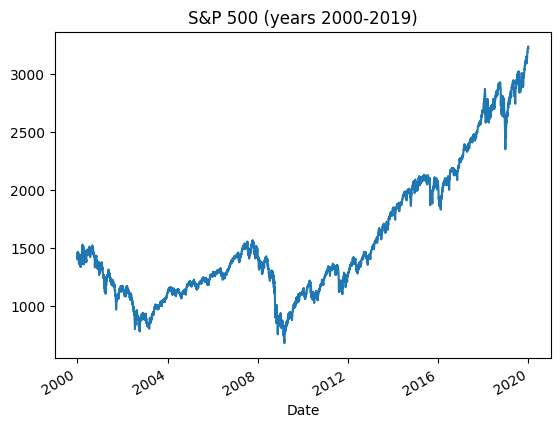

In [37]:
#Detecting patterns in a time series using the Hurst exponent
import yfinance as yf
import numpy as np
import pandas as pd
df = yf.download("^GSPC",
 start="2000-01-01",
 end="2019-12-31",
 progress=False)
df["Adj Close"].plot(title="S&P 500 (years 2000-2019)")

In [2]:
#Detecting patterns in a time series using the Hurst exponent
'''
Hurst exponent is a measure for the long-term memory for a time series, that is , it measures the
amount by which the data deviates from a random walk.
The value of H range between 0 and 1, with the following interpretation

H < 0.5- a series is mean-reverting. The closer value is to 0, 
the stronger the mean-reversion process is.

Mean-reversion–the investors assume that properties such as stock returns and volatility
will revert to their long-term average over time 
(also known as an Ornstein-Uhlenbeck process)

H = 0.5- a series is a geometricx random walk.
H > 0.5- a series is trending. The closer the value is to 1, the stronger the trend.
'''

'\nHurst exponent is a measure for the long-term memory for a time series, that is , it measures the\namount by which the data deviates from a random walk.\nThe value of H range between 0 and 1, with the following interpretation\n\nH < 0.5- a series is mean-reverting. The closer value is to 0, \nthe stronger the mean-reversion process is.\nH = 0.5- a series is a geometricx random walk.\nH > 0.5- a series is trending. The closer the value is to 1, the stronger the trend.\n'

<AxesSubplot: title={'center': 'S&P 500 (years 2000-2019)'}, xlabel='Date'>

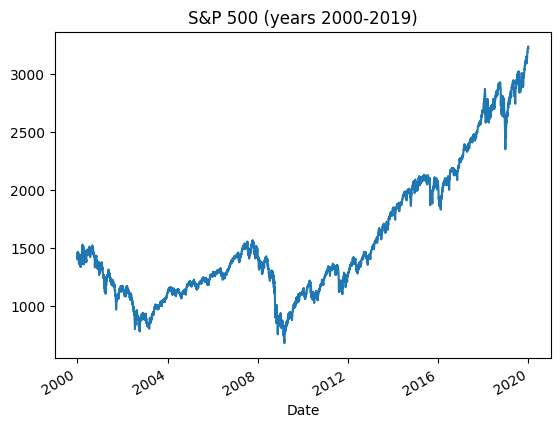

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
df = yf.download("^GSPC",
                 start="2000-01-01",
                 end="2019-12-31",
                 progress=False)
df["Adj Close"].plot(title="S&P 500 (years 2000-2019)")

In [6]:
def get_hurst_exponent( ts, max_lag = 20):
    lags = range(2, max_lag)
    tau = [ np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    hurst_exp = np.polyfit(np.log(lags), np.log(tau), 1)[0]
    return hurst_exp
# ts = time series

In [7]:
for lag in [20, 100, 250, 500, 1000]:
    hurst_exp = get_hurst_exponent(df["Adj Close"].values, lag)
    print(f"Hurst exponent with{lag} lags:{hurst_exp: .4f}")

Hurst exponent with20 lags: 0.4481
Hurst exponent with100 lags: 0.4513
Hurst exponent with250 lags: 0.4918
Hurst exponent with500 lags: 0.5265
Hurst exponent with1000 lags: 0.5178


In [8]:
#The more lags we include, the closer we get to the verdict that the S&P series is a random walk
#narrow down the data to the years 2005 to 2007
shorter_series = df.loc["2005":"2007", "Adj Close"].values
for lag in (20, 100, 250, 500):
    hurst_exp = get_hurst_exponent(shorter_series, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.3989
Hurst exponent with 100 lags: 0.3215
Hurst exponent with 250 lags: 0.2507
Hurst exponent with 500 lags: 0.1258


array([1202.07995605, 1188.05004883, 1183.73999023, 1187.89001465,
       1186.18994141, 1190.25      , 1182.98999023, 1187.69995117,
       1177.44995117, 1184.52001953, 1195.97998047, 1184.63000488,
       1175.41003418, 1167.86999512, 1163.75      , 1168.41003418,
       1174.06994629, 1174.55004883, 1171.35998535, 1181.27001953,
       1189.41003418, 1193.18994141, 1189.89001465, 1203.0300293 ,
       1201.7199707 , 1202.30004883, 1191.98999023, 1197.01000977,
       1205.30004883, 1206.14001465, 1210.11999512, 1210.33996582,
       1200.75      , 1201.58996582, 1184.16003418, 1190.80004883,
       1200.19995117, 1211.36999512, 1203.59997559, 1210.41003418,
       1210.07995605, 1210.4699707 , 1222.11999512, 1225.31005859,
       1219.43005371, 1207.01000977, 1209.25      , 1200.07995605,
       1206.82995605, 1197.75      , 1188.06994629, 1190.20996094,
       1189.65002441, 1183.7800293 , 1171.70996094, 1172.5300293 ,
       1171.42004395, 1174.2800293 , 1165.35998535, 1181.41003

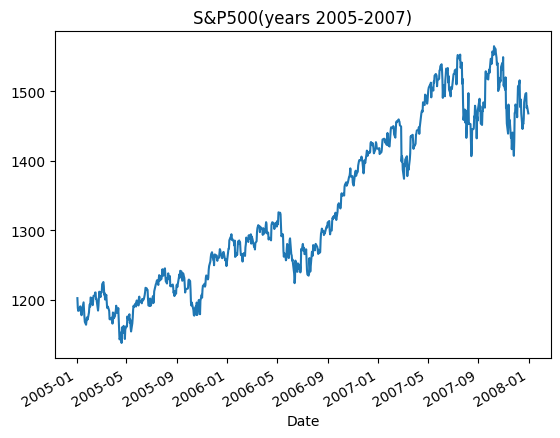

In [16]:
df.loc["2005":"2007", "Adj Close"].plot(title = "S&P500(years 2005-2007)", x = "date")
shorter_series


In [25]:
#Investigating stylized facts of asset returns
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as  plt

In [18]:
df = yf.download("^GSPC", 
                 #"^GSPC" is the ticker symbol for the S&P 500 stock market index.
                 start="2000-01-01",                  
                 end="2020-12-31",
                 progress=False)
df = df[["Adj Close"]].rename(
    columns = {"Adj Close": "adj_close"}
)
df["log_rtn"] = np.log(df["adj_close"]/df["adj_close"].shift(1))
df = df[["adj_close", "log_rtn"]].dropna()

In [27]:
#In this section, we sequentially investigate the fve stylized facts in the S&P 500 returns series:
#fact 1:  Non-Gaussian distribution of returns 
'''
Negative skewness (third moment):
Large negative returns occur more frequently than large positive ones
Excess kurtosis (fourth moment): 
Large (and small) returns occur more ofen than expected under normality
'''
r_range = np.linspace(min(df["log_rtn"]),
                     max(df["log_rtn"]),
                     num = 1000)
mu = df["log_rtn"].mean()
sigma = df["log_rtn"].std()
norm_pdf = scs.norm.pdf(r_range, loc = mu, scale = sigma)

C:\Users\Jackson\AppData\Local\Temp\ipykernel_9436\3038865624.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.log_rtn, kde = False,


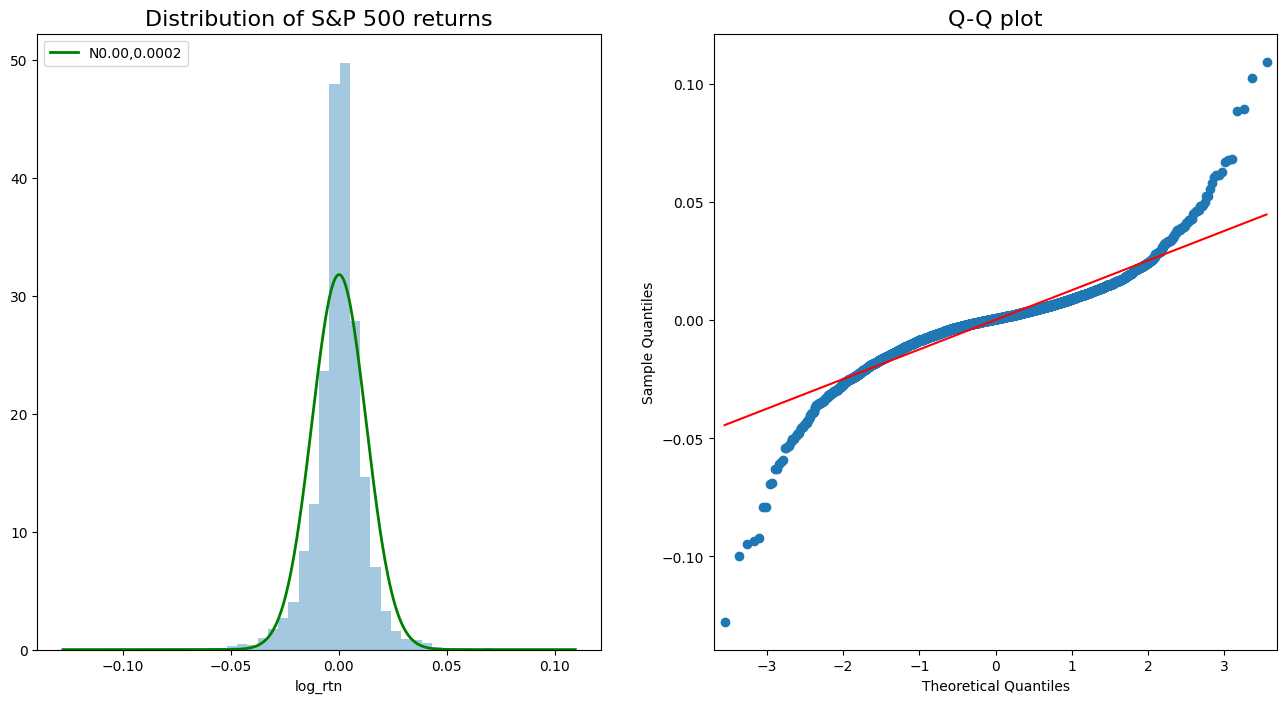

In [33]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
sns.distplot(df.log_rtn, kde = False,
            norm_hist = True, ax = ax[0])
'''
The sns.distplot function in seaborn library is used to plot a univariate distribution 
of observations.
It combines two plots: a histogram and a kernel density estimate (KDE) plot.

The kde parameter is used to control whether the KDE plot should be displayed or not.
The KDE plot is a smoothed representation of the distribution of the data
Setting kde=True will show the KDE plot, and setting kde=False will hide it.

The norm_hist parameter is used to normalize the histogram plot so that the total area under the histogram equals 1. 
Setting norm_hist=True will normalize the histogram, 
and setting norm_hist=False will show the raw counts in the histogram.
'''
ax[0].set_title("Distribution of S&P 500 returns",
               fontsize = 16)
ax[0].plot(r_range, norm_pdf, "g", lw = 2,
          label = f"N{mu:.2f},{sigma**2:.4f}")
#g = green, lw = linewidth
ax[0].legend(loc = "upper left")

qq = sm.qqplot(df.log_rtn.values, line = "s", ax = ax[1])
'''
The sm.qqplot() function is used to plot a quantile-quantile (Q-Q) plot in the second subplot (ax[1]) of the figure.

A quantile-quantile (Q-Q) plot is a graphical method
for comparing the distribution of a sample of data to a theoretical distribution, such as a normal distribution. 

The line="s" parameter specifies that a standardized line (i.e., a line with slope 1 and intercept 0) 
is to be added to the plot for comparison purposes.

'''
ax[1].set_title("Q-Q plot", fontsize = 16)
             
plt.show()

<AxesSubplot: title={'center': 'Daily S&P 500 returns'}, xlabel='Date'>

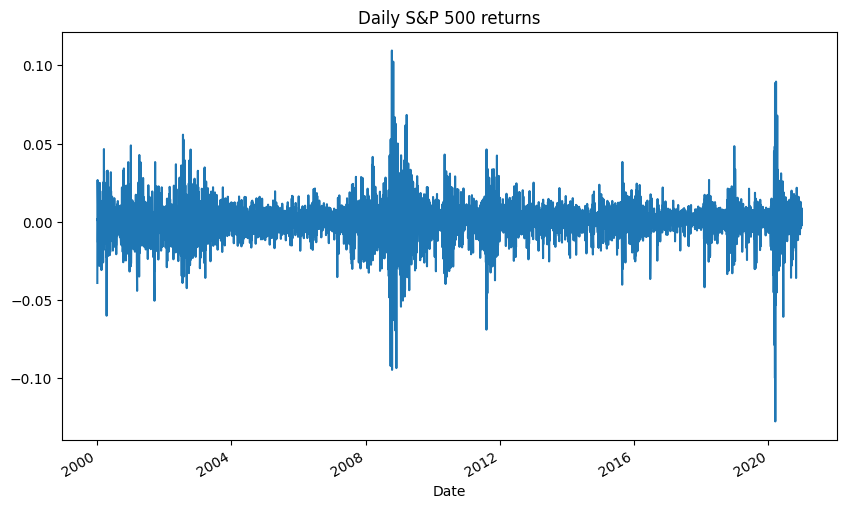

In [34]:
#Fact 2: Volatility clustering
'''
Volatility clustering is the pattern in which large changes in prices
tend to be followed by large changes (periods of higher volatility), 
while small changes in price are followed by small changes (periods of lower volatility).
'''
(
    df["log_rtn"]
    .plot(title = "Daily S&P 500 returns", figsize = (10, 6))
)

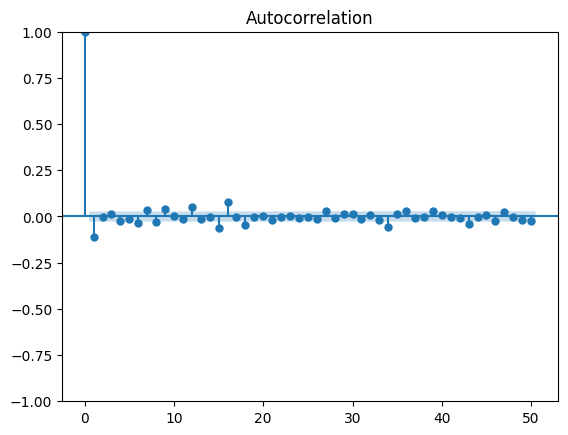

In [35]:
#Fact 3: Absence of auto correlation in returns
'''
Autocorrelation (also known as serial correlation) measures 
how similar a given time series is to the lagged version of itself over successive time intervals. 
'''
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05
acf = smt.graphics.plot_acf(df["log_rtn"],
                           lags = N_LAGS,
                           alpha = SIGNIFICANCE_LEVEL)
#alpha: the significance level for the confidence intervals
plt.show()
#Only a few values lie outside of the confidence interval(we do not look at lag 0)
#and can be considered statistically significant. We can assume that we have vertified
#that there is no autocorrelation in the log-returns series

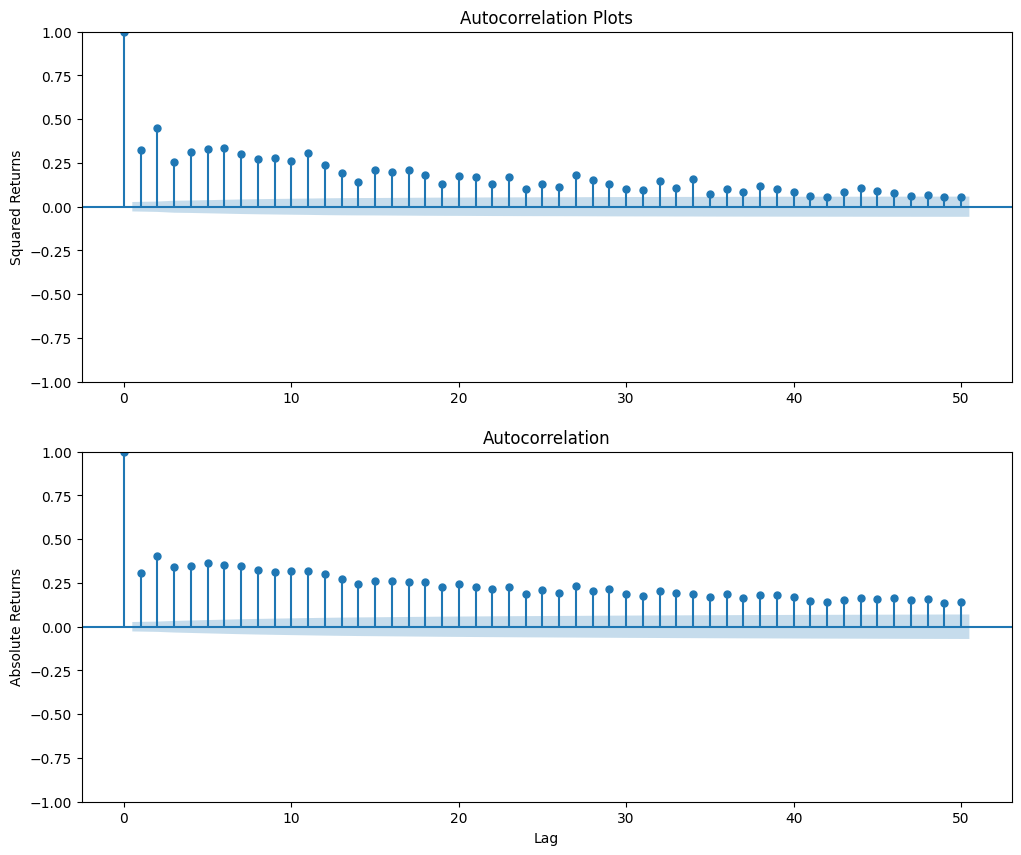

In [36]:
#Fact 4: Small and decreasing autocorrelation in squared/absolute returns
#The autocorrelation function of the squared returns is a common measure of volatility clustering
fig, ax = plt.subplots(2, 1, figsize = (12, 10))
smt.graphics.plot_acf(df["log_rtn"]**2, lags = N_LAGS,
                     alpha = SIGNIFICANCE_LEVEL, ax = ax[0])
ax[0].set(title = "Autocorrelation Plots",
         ylabel = "Squared Returns")
smt.graphics.plot_acf(np.abs(df["log_rtn"]), lags = N_LAGS,
                     alpha = SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(ylabel = "Absolute Returns",
         xlabel = "Lag")
plt.show()

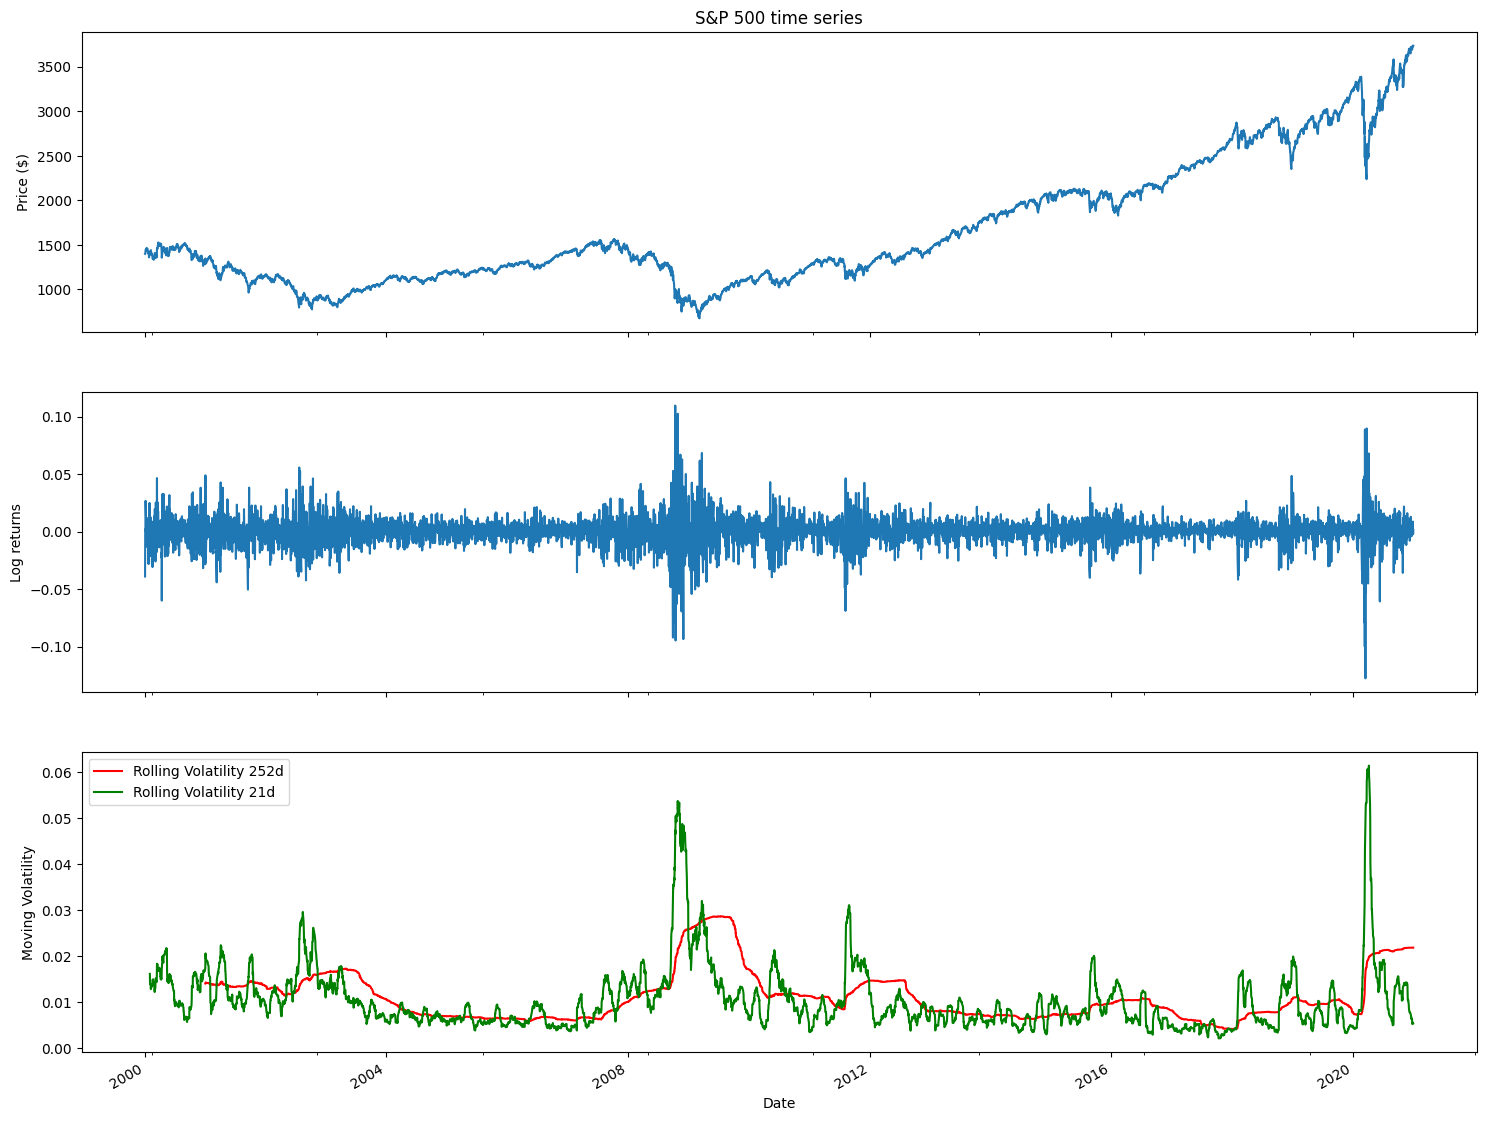

In [38]:
#Fact 5: Leverage effect    
'''
calculates and plots the moving standard deviation of the log returns of the S&P 500 stock market index.
'''
df["moving_std_252"] = df[["log_rtn"]].rolling(window = 252).std()
df["moving_std_21"] = df[["log_rtn"]].rolling(window = 21).std()

fig, ax = plt.subplots(3, 1, figsize = (18, 15),
                      sharex = True)
df["adj_close"].plot(ax=ax[0])
ax[0].set(title="S&P 500 time series",         
          ylabel="Price ($)")
df["log_rtn"].plot(ax=ax[1])
ax[1].set(ylabel="Log returns")
df["moving_std_252"].plot(ax = ax[2], color = "r", label = "Rolling Volatility 252d")
df["moving_std_21"].plot(ax = ax[2], color = "g", label = "Rolling Volatility 21d")
ax[2].set(ylabel = "Moving Volatility",
         xlabel = "Date")
ax[2].legend()
plt.show()
'''

The "leverage effect" is a phenomenon in finance where a company's financial risk and volatility increase as it takes on more debt.
In the context of the stock market, the leverage effect refers to the fact that volatility tends to increase when the market is declining.
This is because companies with high levels of debt are more vulnerable to economic downturns,
and their stock prices may decline more sharply than companies with less debt.
we can observe a pattern of increased volatility 
when the prices go down and decreased volatility when they are rising. 
This observation is in line with the fact’s defnition.
'''

In [39]:
df = yf.download(["^GSPC", "^VIX"],
                 start="2000-01-01",
                 end="2020-12-31",
                 progress=False)
df = df[["Adj Close"]]
df.columns = df.columns.droplevel(0)
df = df.rename(columns={"^GSPC": "sp500", "^VIX": "vix"})
df["log_rtn"] = np.log(df["sp500"] / df["sp500"].shift(1))
df["vol_rtn"] = np.log(df["vix"] / df["vix"].shift(1))
df.dropna(how="any", axis=0, inplace=True)

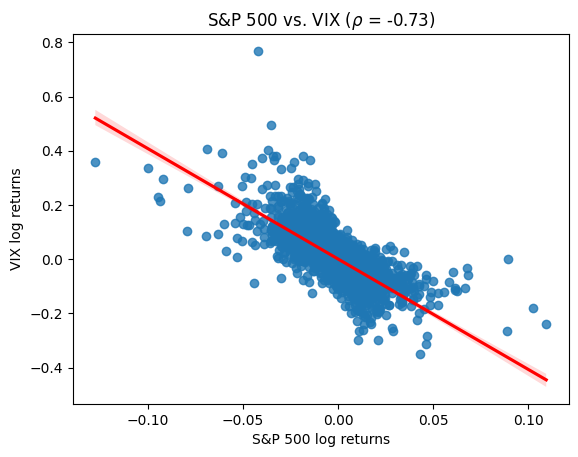

In [47]:
'''

We present another method of investigating the leverage effect.
To do so,we use the VIX(CBOE VolatilityIndex),
which is a popular metric of the stock market’s expectations regarding volatility 
and calculates annualized expected volatility of the S&P 500 index over the next 30 days. 
'''
corr_coeff = df.log_rtn.corr(df.vol_rtn)
#3.Plot a scatterplot with the returns on the axies
#and fit a regression line to identify the trend:
ax = sns.regplot(x = "log_rtn", y = "vol_rtn", data = df, line_kws={
                    "color":"red"
                 })
ax.set(title=f"S&P 500 vs. VIX ($\\rho$ = {corr_coeff:.2f})",
      ylabel = "VIX log returns",
      xlabel = "S&P 500 log returns")
plt.show()
#We can see that both the negative slope of the regression line and a strong negative correlation
#between the two series confrm the existence of the leverage efect in the return series.